In [1]:
import torch, os
import numpy as np
from torchvision import transforms
from torch.utils import data
from PIL import Image
import pandas as pd
import warnings
from torchvision import transforms
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

BATCH_SIZE = 256
NUM_WORKERS = 4
SPLIT_RATIO = 0.9
RANDOM_SEED = 123
CLASS_NUM = 200
ROOT = r'./CUB_200_2011'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Utils Functions

In [17]:
def imshow(image, label, ax=None, normalize=True):
    """show single along with label on an ax"""
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(label)

    return ax


def show_samples(images, labels, nrows=2, ncols=3, title=None, normalize=True):
    """ show multiple samples

    args:
        nrows (int, optional): number of row
        ncols (int, optional): number of column
        title (str, optional): title.
        normalize (bool, optional): whether the images are normalized
    """
    fig, axes = plt.subplots(nrows, ncols, facecolor='#ffffff', dpi=100)

    # .flat: to map samples to multi-dimensional axes
    for (ax, image, label) in zip(axes.flat, images, labels):
        ax = imshow(image, label.item(), ax, normalize)

    fig.suptitle(title)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.85, hspace=0.3)
    plt.show()

### Load in Dataset

In [3]:
class CUB():
    def __init__(self, root, dataset_type='train', train_ratio=1, valid_seed=123, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        df_img = pd.read_csv(os.path.join(root, 'images.txt'), sep=' ', header=None, names=['ID', 'Image'], index_col=0)
        df_label = pd.read_csv(os.path.join(root, 'image_class_labels.txt'), sep=' ', header=None, names=['ID', 'Label'], index_col=0)
        df_split = pd.read_csv(os.path.join(root, 'train_test_split.txt'), sep=' ', header=None, names=['ID', 'Train'], index_col=0)
        df = pd.concat([df_img, df_label, df_split], axis=1)
        # relabel
        df['Label'] = df['Label'] - 1

        # split data
        if dataset_type == 'test':
            df = df[df['Train'] == 0]
        elif dataset_type == 'train' or dataset_type == 'valid':
            df = df[df['Train'] == 1]
            # random split train, valid
            if train_ratio != 1:
                np.random.seed(valid_seed)
                indices = list(range(len(df)))
                np.random.shuffle(indices)
                split_idx = int(len(indices) * train_ratio) + 1
            elif dataset_type == 'valid':
                raise ValueError('train_ratio should be less than 1!')
            if dataset_type == 'train':
                df = df.iloc[indices[:split_idx]]
            else:       # dataset_type == 'valid'
                df = df.iloc[indices[split_idx:]]
        else:
            raise ValueError('Unsupported dataset_type!')
        self.img_name_list = df['Image'].tolist()
        self.label_list = df['Label'].tolist()
        # Convert greyscale images to RGB mode
        self._convert2rgb()

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.img_name_list[idx])
        image = Image.open(img_path)
        target = self.label_list[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

    def _convert2rgb(self):
        for i, img_name in enumerate(self.img_name_list):
            img_path = os.path.join(self.root, 'images', img_name)
            image = Image.open(img_path)
            if image.mode != 'RGB':
                rgb_image_path = img_path.replace('.jpg', '_rgb.jpg')
                rgb_image_dir = os.path.dirname(rgb_image_path)
                if not os.path.exists(rgb_image_dir):
                    os.makedirs(rgb_image_dir)
                image = image.convert('RGB')
                image.save(rgb_image_path)
                self.img_name_list[i] = img_name.replace('.jpg', '_rgb.jpg')

Define transformation

In [4]:
trans_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trans_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = CUB(ROOT, 'train', SPLIT_RATIO, RANDOM_SEED, transform=trans_train)
valid_data = CUB(ROOT, 'valid', SPLIT_RATIO, RANDOM_SEED, transform=trans_test)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)

print("Train: {}".format(len(train_data)))
print("Valid: {}".format(len(valid_data)))

Train: 5395
Valid: 599


Image Demo

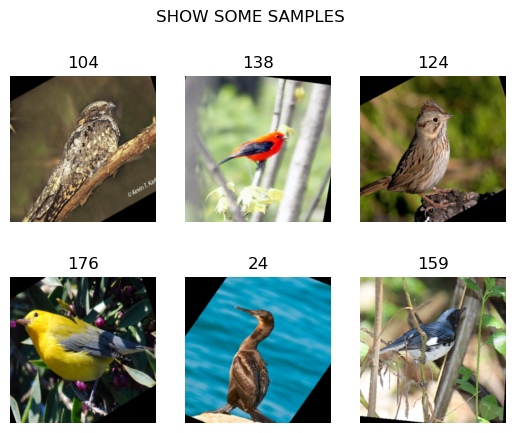

In [18]:
images, labels = next(iter(train_loader))
show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME SAMPLES')

### Define Networks

In [6]:
# import torch.nn as nn
# from torchvision import models
# from collections import OrderedDict
# import torch.optim as optim

# model = models.resnet18(pretrained=True)
# num_classes = 200
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD([
#     {'params': model.fc.parameters(), 'lr': 0.01},
#     {'params': [param for name, param in model.named_parameters() if "fc" not in name], 'lr': 0.001}
# ], momentum=0.9, weight_decay=5e-4)

# SPLIT_RATIO = 0.8  # Example split ratio
# RANDOM_SEED = 42
# BATCH_SIZE = 64
# NUM_WORKERS = 4
# NUM_EPOCHS = 10


In [7]:
# from tqdm import tqdm
# from torch.utils.tensorboard import SummaryWriter

# def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=NUM_EPOCHS, tensorboard_log_dir='runs/cub200_resnet18'):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)
    
#     best_acc = 0.0
#     writer = SummaryWriter(log_dir=tensorboard_log_dir)
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0

#         train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs - 1} - Training')
#         for inputs, labels in train_loader_tqdm:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item() * inputs.size(0)
#             _, preds = torch.max(outputs, 1)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(train_loader.dataset)
#         epoch_acc = running_corrects.double() / len(train_loader.dataset)

#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print(f'Training Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.4f}%')

#         model.eval()
#         val_loss = 0.0
#         val_corrects = 0

#         with torch.no_grad():
#             for inputs, labels in valid_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item() * inputs.size(0)
#                 _, preds = torch.max(outputs, 1)
#                 val_corrects += torch.sum(preds == labels.data)

#         val_loss /= len(valid_loader.dataset)
#         val_acc = val_corrects.double() / len(valid_loader.dataset)

#         # Log validation loss and accuracy to TensorBoard
#         writer.add_scalar('Loss/train', epoch_loss, epoch)
#         writer.add_scalar('Loss/validation', val_loss, epoch)
#         writer.add_scalar('Accuracy/train', epoch_acc, epoch)
#         writer.add_scalar('Accuracy/validation', val_acc, epoch)

#         print(f'Validation Loss: {val_loss:.4f} Acc: {100*val_acc:.4f}%')

#         if val_acc > best_acc:
#             best_acc = val_acc
#             torch.save(model.state_dict(), 'best_model.pth')

#     print(f'Best Validation Accuracy: {100*best_acc:.4f}%')
#     writer.close()
#     return best_acc



In [8]:
# # Train the model
# pretrained_best_acc = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=NUM_EPOCHS, tensorboard_log_dir='runs/cub200_resnet18_pretrained')

In [9]:
# # Model setup for ResNet-18 trained from scratch
# model.to('cpu')
# del model
# model_scratch = models.resnet18(pretrained=False)
# model_scratch.fc = nn.Linear(model_scratch.fc.in_features, num_classes)
# model_scratch.to(device)

# # Define optimizer for the model trained from scratch
# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# # Train the model from scratch
# scratch_best_acc = train_model(model_scratch, criterion, optimizer_scratch, train_loader, valid_loader, num_epochs=NUM_EPOCHS, tensorboard_log_dir='runs/cub200_resnet18_scratch')

In [10]:
# print("Comparison of Pre-trained vs. Scratch Training on CUB-200-2011 dataset")
# print(f"Best Validation Accuracy (Pre-trained): {100*pretrained_best_acc:.4f}%")
# print(f"Best Validation Accuracy (Scratch): {100*scratch_best_acc:.4f}%")


In [11]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm

# Define the model
num_classes = 200

def get_model(pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define hyperparameter grid
learning_rates = [0.01, 0.001, 0.005]
num_epochs_list = [20, 30, 40]


def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, tensorboard_log_dir):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_acc = 0.0
    writer = SummaryWriter(log_dir=tensorboard_log_dir)

    pbar = tqdm(total=num_epochs, desc='Training Progress')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

        val_loss /= len(valid_loader.dataset)
        val_acc = val_corrects / len(valid_loader.dataset)

        # Log validation loss and accuracy to TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        writer.add_scalar('Accuracy/validation', val_acc, epoch)

        pbar.set_postfix({'Train Acc': 100 * epoch_acc, 'Val Acc': 100 * val_acc})
        pbar.update(1)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print(f'Best Validation Accuracy: {100*best_acc:.4f}%')
    writer.close()
    pbar.close()
    return best_acc


2024-05-31 15:50:22.959663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 15:50:29.191180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
best_overall_acc = 0.0
best_hyperparams = {}
best_model_state = None

for lr in learning_rates:
    for num_epochs in num_epochs_list:
        model = get_model(pretrained=True)
        optimizer = optim.SGD([
            {'params': model.fc.parameters(), 'lr': lr},
            {'params': [param for name, param in model.named_parameters() if "fc" not in name], 'lr': lr / 10}
        ], momentum=0.9, weight_decay=5e-4)

        tensorboard_log_dir = f'runs/cub200_resnet18_pretrained_lr_{lr}_epochs_{num_epochs}'
        print(f'Training with learning rate: {lr}, epochs: {num_epochs}')
        best_acc = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=num_epochs, tensorboard_log_dir=tensorboard_log_dir)
        print(f'Best accuracy for lr {lr} and epochs {num_epochs}: {best_acc}')

        if best_acc > best_overall_acc:
            best_overall_acc = best_acc
            best_hyperparams = {'learning_rate': lr, 'num_epochs': num_epochs}
            best_model_state = model.state_dict()

print(f'Best overall accuracy: {100*best_overall_acc:.4f}% with hyperparameters: {best_hyperparams}')

if best_model_state:
    torch.save({'model_state_dict': best_model_state, 'hyperparams': best_hyperparams}, 'best_model_with_hyperparams.pth')


Training with learning rate: 0.01, epochs: 20


Training Progress: 100%|██████████| 20/20 [08:06<00:00, 24.31s/it, Train Acc=83.6, Val Acc=69.1]


Best Validation Accuracy: 69.1152%
Best accuracy for lr 0.01 and epochs 20: 0.6911519198664441
Training with learning rate: 0.01, epochs: 30


Training Progress: 100%|██████████| 30/30 [10:43<00:00, 21.44s/it, Train Acc=88.7, Val Acc=68.6]


Best Validation Accuracy: 69.2821%
Best accuracy for lr 0.01 and epochs 30: 0.6928213689482471
Training with learning rate: 0.01, epochs: 40


Training Progress: 100%|██████████| 40/40 [14:09<00:00, 21.24s/it, Train Acc=92.7, Val Acc=70.3]


Best Validation Accuracy: 70.2838%
Best accuracy for lr 0.01 and epochs 40: 0.7028380634390651
Training with learning rate: 0.001, epochs: 20


Training Progress: 100%|██████████| 20/20 [07:18<00:00, 21.91s/it, Train Acc=26.1, Val Acc=19.7] 


Best Validation Accuracy: 19.6995%
Best accuracy for lr 0.001 and epochs 20: 0.19699499165275458
Training with learning rate: 0.001, epochs: 30


Training Progress: 100%|██████████| 30/30 [11:08<00:00, 22.27s/it, Train Acc=41.3, Val Acc=35.2] 


Best Validation Accuracy: 35.2254%
Best accuracy for lr 0.001 and epochs 30: 0.35225375626043404
Training with learning rate: 0.001, epochs: 40


Training Progress: 100%|██████████| 40/40 [14:50<00:00, 22.26s/it, Train Acc=50, Val Acc=38.6]   


Best Validation Accuracy: 38.5643%
Best accuracy for lr 0.001 and epochs 40: 0.38564273789649417
Training with learning rate: 0.005, epochs: 20


Training Progress: 100%|██████████| 20/20 [07:25<00:00, 22.29s/it, Train Acc=72.1, Val Acc=58.3]


Best Validation Accuracy: 58.2638%
Best accuracy for lr 0.005 and epochs 20: 0.5826377295492488
Training with learning rate: 0.005, epochs: 30


Training Progress: 100%|██████████| 30/30 [11:06<00:00, 22.22s/it, Train Acc=79.9, Val Acc=62.8]


Best Validation Accuracy: 63.4391%
Best accuracy for lr 0.005 and epochs 30: 0.6343906510851419
Training with learning rate: 0.005, epochs: 40


Training Progress: 100%|██████████| 40/40 [14:44<00:00, 22.12s/it, Train Acc=83.4, Val Acc=67.4] 


Best Validation Accuracy: 67.4457%
Best accuracy for lr 0.005 and epochs 40: 0.674457429048414
Best overall accuracy: 70.2838% with hyperparameters: {'learning_rate': 0.01, 'num_epochs': 40}


In [15]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm

# Define the model
num_classes = 200

def get_model(pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define hyperparameter grid
learning_rates = [0.01, 0.001, 0.005]
num_epochs_list = [20, 30, 40]

def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, tensorboard_log_dir):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_acc = 0.0
    writer = SummaryWriter(log_dir=tensorboard_log_dir)

    pbar = tqdm(total=num_epochs, desc='Training Progress')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

        val_loss /= len(valid_loader.dataset)
        val_acc = val_corrects / len(valid_loader.dataset)

        # Log validation loss and accuracy to TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        writer.add_scalar('Accuracy/validation', val_acc, epoch)

        pbar.set_postfix({'Train Acc': 100 * epoch_acc, 'Val Acc': 100 * val_acc})
        pbar.update(1)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'scartch_best_model.pth')

    print(f'Best Validation Accuracy: {100*best_acc:.4f}%')
    writer.close()
    pbar.close()
    return best_acc



In [16]:
best_overall_acc = 0.0
best_hyperparams = {}
best_model_state = None

for lr in learning_rates:
    for num_epochs in num_epochs_list:
        model = get_model(pretrained=False)
        optimizer = optim.SGD([
            {'params': model.fc.parameters(), 'lr': lr},
            {'params': [param for name, param in model.named_parameters() if "fc" not in name], 'lr': lr / 10}
        ], momentum=0.9, weight_decay=5e-4)

        tensorboard_log_dir = f'runs/cub200_resnet18_scratch_lr_{lr}_epochs_{num_epochs}'
        print(f'Training with learning rate: {lr}, epochs: {num_epochs}')
        best_acc = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=num_epochs, tensorboard_log_dir=tensorboard_log_dir)
        print(f'Best accuracy for lr {lr} and epochs {num_epochs}: {best_acc}')

        if best_acc > best_overall_acc:
            best_overall_acc = best_acc
            best_hyperparams = {'learning_rate': lr, 'num_epochs': num_epochs}
            best_model_state = model.state_dict()

print(f'Best overall accuracy: {100*best_overall_acc:.4f}% with hyperparameters: {best_hyperparams}')

if best_model_state:
    torch.save({'model_state_dict': best_model_state, 'hyperparams': best_hyperparams}, 'scratch_best_model_with_hyperparams.pth')


Training with learning rate: 0.01, epochs: 20


Training Progress: 100%|██████████| 20/20 [07:15<00:00, 21.76s/it, Train Acc=6.34, Val Acc=4.34] 


Best Validation Accuracy: 4.3406%
Best accuracy for lr 0.01 and epochs 20: 0.04340567612687813
Training with learning rate: 0.01, epochs: 30


Training Progress: 100%|██████████| 30/30 [10:52<00:00, 21.74s/it, Train Acc=9.34, Val Acc=5.68] 


Best Validation Accuracy: 5.8431%
Best accuracy for lr 0.01 and epochs 30: 0.05843071786310518
Training with learning rate: 0.01, epochs: 40


Training Progress: 100%|██████████| 40/40 [14:18<00:00, 21.46s/it, Train Acc=12.3, Val Acc=6.51] 


Best Validation Accuracy: 7.6795%
Best accuracy for lr 0.01 and epochs 40: 0.07679465776293823
Training with learning rate: 0.001, epochs: 20


Training Progress: 100%|██████████| 20/20 [07:01<00:00, 21.06s/it, Train Acc=1.35, Val Acc=0.167] 


Best Validation Accuracy: 1.1686%
Best accuracy for lr 0.001 and epochs 20: 0.011686143572621035
Training with learning rate: 0.001, epochs: 30


Training Progress: 100%|██████████| 30/30 [10:25<00:00, 20.83s/it, Train Acc=1.95, Val Acc=0.334] 


Best Validation Accuracy: 0.6678%
Best accuracy for lr 0.001 and epochs 30: 0.00667779632721202
Training with learning rate: 0.001, epochs: 40


Training Progress: 100%|██████████| 40/40 [13:32<00:00, 20.32s/it, Train Acc=2.11, Val Acc=0.501] 


Best Validation Accuracy: 0.6678%
Best accuracy for lr 0.001 and epochs 40: 0.00667779632721202
Training with learning rate: 0.005, epochs: 20


Training Progress: 100%|██████████| 20/20 [06:53<00:00, 20.66s/it, Train Acc=3.39, Val Acc=1]    


Best Validation Accuracy: 1.6694%
Best accuracy for lr 0.005 and epochs 20: 0.01669449081803005
Training with learning rate: 0.005, epochs: 30


Training Progress: 100%|██████████| 30/30 [10:24<00:00, 20.80s/it, Train Acc=5.56, Val Acc=4.67] 


Best Validation Accuracy: 4.6745%
Best accuracy for lr 0.005 and epochs 30: 0.04674457429048414
Training with learning rate: 0.005, epochs: 40


Training Progress: 100%|██████████| 40/40 [13:34<00:00, 20.36s/it, Train Acc=7.49, Val Acc=4.34] 


Best Validation Accuracy: 4.3406%
Best accuracy for lr 0.005 and epochs 40: 0.04340567612687813
Best overall accuracy: 7.6795% with hyperparameters: {'learning_rate': 0.01, 'num_epochs': 40}
